In [135]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [358]:
# import jobfair_train.csv
df=pd.read_csv("league_rank_train.csv")

# Data Cleaning, Variable Selection and Data Exploration

In [137]:
# take a look at first 5 rows
df.head()

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
0,173,6042825,2912348,2) Minnow,134,25,5.255151,4.483009,1.778801,25,...,Portugal,Flash FB Canvas,24,435,11.0,598,245,186,818,2
1,173,9620967,2912140,2) Minnow,28,23,4.962521,4.785648,-0.002687,28,...,Turkey,Android Phone,19,58,7.0,269,0,35,24,2
2,173,6045474,2912933,4) Whale,136,23,11.105782,10.511133,0.628794,28,...,Belgium,Flash FB Canvas,26,116,8.0,23180,369,444,4933,1
3,173,14187773,2910371,0) NonPayer,2,21,4.164848,4.023486,0.551904,12,...,Malaysia,Android Phone,11,22,2.0,41,43,213,126,6
4,173,13694853,2907632,0) NonPayer,5,22,3.031939,2.926029,0.690544,0,...,Italy,iOS Phone,9,0,4.0,0,16,100,147,10


In [138]:
df.shape

(55314, 23)

- I would like to first talk about the dataset from a qualitative point of view

#### season

In [139]:
df["season"].nunique()

1

- season has only 1 unique value, representing the id of the last season. This variable therefore has no predictive power
  and will be dropped from the dataset

#### club_id

- club_id is the unique identifier of the user so it will also be dropped from the dataset

#### league_id

In [140]:
# checking that each club indeed competes in one league
len(df.groupby("club_id").filter(lambda x: x['league_id'].nunique() > 1)["club_id"])

0

In [141]:
df["league_id"].nunique()

3951

- Each club competes in 1 league. I believe that this feature should be excluded from the rest of the analysis since the league_id (or we could think about it as league name) has no effect on the ranking. Ranking is determined by competing with other players within the league, not the league name itself. Also there are 3951 different league ids, which means that once converted to dummy variables we would be adding a lot of columns to our training dataset, substantially increasing the size of the trainig dataset and the execution time of the model, eventhough the dataset has only 55314 rows

#### registration_country

In [142]:
print(df["registration_country"].isna().sum())
print(df["registration_country"].nunique())

0
186


- I am really interested in seeing the distribution of mean ranking on a per country basis. It could be the case that those    coming from richer countries and can spend more have higher average rankings or perhaps some players from some countries are just better.   
- Let's explore this idea

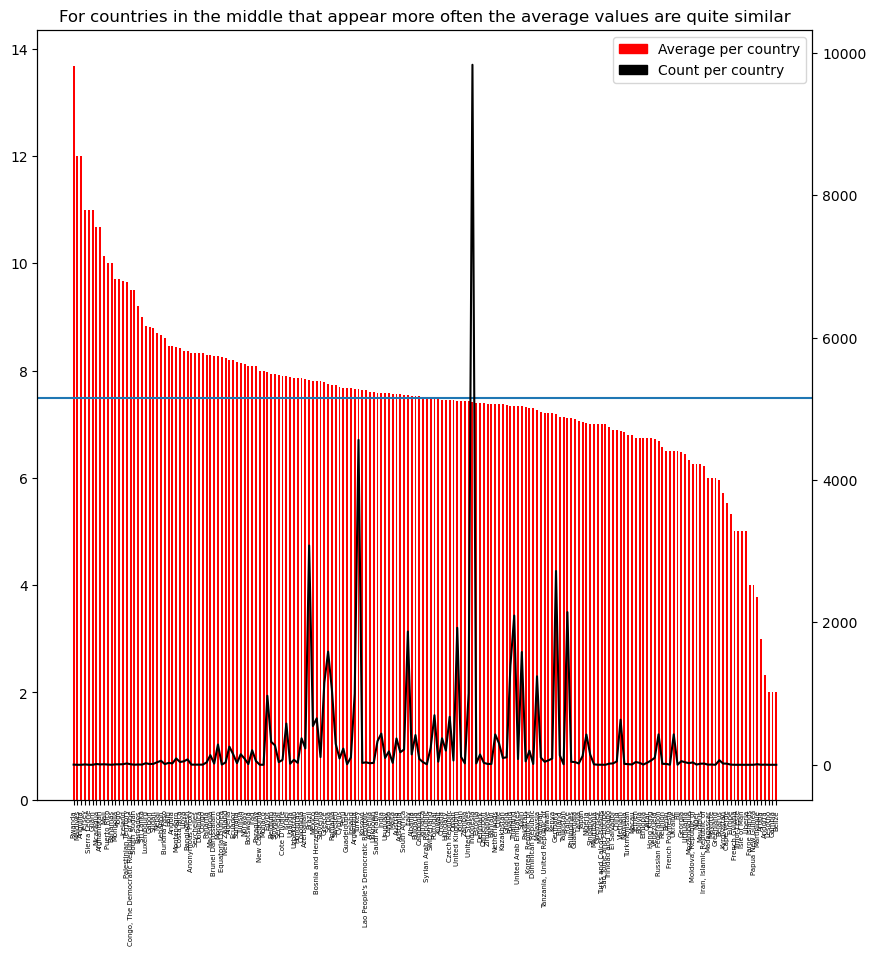

In [143]:
grouped=df.groupby("registration_country").agg({"league_rank":["mean","median","count"]}).droplevel(0,axis=1).reset_index()\
                                  .sort_values("mean",ascending=False)
grouped["mean"].mean()
plt.figure(figsize=(10,10))
plt.bar(data=grouped,x="registration_country",height="mean",color="red",width=0.5)
plt.axhline(y=grouped["mean"].mean())
plt.xticks(rotation=90,fontsize=5)
plt2=plt.twinx()
plt2.plot("registration_country","count",data=grouped,color="black")
plt.title("For countries in the middle that appear more often the average values are quite similar")
average = mpatches.Patch(color='red', label='Average per country')
count = mpatches.Patch(color='black', label='Count per country')
plt.legend(handles=[average, count])
plt.show()


- Looking at the plots above, we see that countries with a very low number of appearances have either very high or very low average rankings, due to the fact that there have not been enough values to converge the mean to higher/lower value, as is the case for most of the other countries appearing more often

- Since I will be running a liner regression later I believe that many of the coefficients will be insignificant for this variable, since as this would be a dummy variable, whilst controlling for other variables, we would be looking at, by how much, on average we can expecet the league_rank to increase when comparing our base country to any other country. However with means so close to each other it seems there would not be much effect

- Later when I run RF and XGBoost, which rely on decision trees, it seems that any split by a country would result in a value close to the overall mean of league_rank, therefore indicating a low importance of this feature, since it is unable to split the data well, but let's see throughout the analysis if my assumptions hold true

#### registration platform specific

- I would like to repeat the analysis for the previous feature on this feature as well

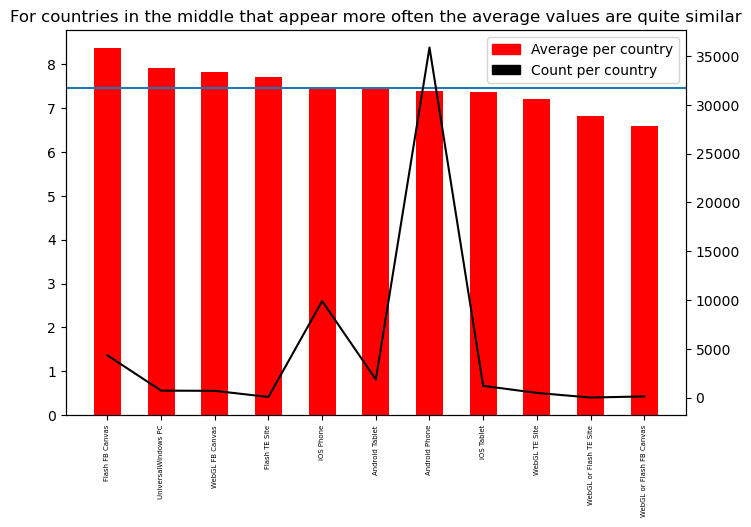

In [144]:
grouped=df.groupby("registration_platform_specific").agg({"league_rank":["mean","median","count"]}).droplevel(0,axis=1).reset_index()\
                                  .sort_values("mean",ascending=False)
plt.figure(figsize=(8,5))
plt.bar(data=grouped,x="registration_platform_specific",height="mean",color="red",width=0.5)
plt.axhline(y=grouped["mean"].mean())
plt.xticks(rotation=90,fontsize=5)
plt2=plt.twinx()
plt2.plot("registration_platform_specific","count",data=grouped,color="black")
plt.title("For countries in the middle that appear more often the average values are quite similar")
average = mpatches.Patch(color='red', label='Average per country')
count = mpatches.Patch(color='black', label='Count per country')
plt.legend(handles=[average, count])
plt.show()

- Let's check the data types of variables

In [145]:
df.dtypes

season                                       int64
club_id                                      int64
league_id                                    int64
dynamic_payment_segment                     object
cohort_season                                int64
avg_age_top_11_players                       int64
avg_stars_top_11_players                   float64
avg_stars_top_14_players                   float64
avg_training_factor_top_11_players         float64
days_active_last_28_days                     int64
league_match_watched_count_last_28_days      int64
session_count_last_28_days                   int64
playtime_last_28_days                        int64
registration_country                        object
registration_platform_specific              object
league_match_won_count_last_28_days          int64
training_count_last_28_days                  int64
global_competition_level                   float64
tokens_spent_last_28_days                    int64
tokens_stash                   

- Nothing wrong here :)

- Check for the existance of NaN values

In [146]:
df.isna().sum()

season                                         0
club_id                                        0
league_id                                      0
dynamic_payment_segment                        0
cohort_season                                  0
avg_age_top_11_players                         0
avg_stars_top_11_players                       0
avg_stars_top_14_players                       0
avg_training_factor_top_11_players             0
days_active_last_28_days                       0
league_match_watched_count_last_28_days        0
session_count_last_28_days                     0
playtime_last_28_days                          0
registration_country                           0
registration_platform_specific                 0
league_match_won_count_last_28_days            0
training_count_last_28_days                    0
global_competition_level                   17551
tokens_spent_last_28_days                      0
tokens_stash                                   0
rests_stash         

- There are no NaN values except for global_competition_level. This is justified since users may or may not take part in global competition. The variable, however has 17551 rows missing, so it would not be a good idea to just drop the rows. The variable can be imputed. Since none of the other variables are missing I will use Random Forest later to impute this variable

#### playtime_last_28_days 

In [359]:
df[["playtime_last_28_days"]].describe(percentiles=[0.25,0.5,0.75,0.95,0.99]).apply(lambda s: s.apply('{0:.5f}'.format))

,playtime_last_28_days
count,55314.00000
mean,29551777.03965
std,52338916.28240
min,0.00000
25%,73641.50000
50%,6230431.00000
75%,37687108.00000
95%,131193486.40000
99%,232943666.75000
max,1340478682.00000


In [117]:
df[df["playtime_last_28_days"]==df["playtime_last_28_days"].max()]

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
43779,173,8521619,2911533,0) NonPayer,36,22,6.114497,5.781162,0.440141,28,...,Greece,WebGL TE Site,17,178,9.0,233,18,107,7,4


- This variable has been defined as being in minutes in task description. However there are only 40,320 minutes and 2,419,200 seconds in 28 days. The values also can't be the total number of minutes or seconds since the user signed up, since for the player with the maximum value for this variable if they played all day long for 36 seasons this would be 1,451,520 minutes or 87,091,200 seconds. The only plausible explanation I can find is that these are miliseconds. However, I will keep this variable as such, since by changing the scale I would not be increasing it's predictive power

### Check for outliers

In [360]:
df.describe(percentiles=[0.25,0.5,0.75,0.95,0.99]).apply(lambda s: s.apply('{0:.5f}'.format))

,season,club_id,league_id,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,league_match_watched_count_last_28_days,session_count_last_28_days,playtime_last_28_days,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
count,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,37763.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000
mean,173.00000,12109765.38101,2909804.22172,23.40937,23.71866,4.53352,4.34478,0.58437,12.35709,3.62317,63.43217,29551777.03965,12.41181,61.10769,3.90101,121.39390,113.13308,283.08352,307.08596,7.50000
std,0.00000,3384016.19841,2102.13994,42.00927,2.20624,1.20475,1.17707,0.17809,11.84910,5.90605,101.83167,52338916.28240,6.40301,188.28828,2.62558,842.77553,3183.55040,789.25096,823.36249,4.03117
min,173.00000,275.00000,2904743.00000,1.00000,18.00000,1.45170,1.35490,-1.28774,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,-4975.00000,-169.00000,0.00000,1.00000
25%,173.00000,11511047.00000,2907961.00000,2.00000,22.00000,3.69114,3.50006,0.47957,1.00000,0.00000,1.00000,73641.50000,8.00000,0.00000,1.00000,0.00000,11.00000,41.00000,52.00000,4.00000
50%,173.00000,13928215.50000,2910038.00000,4.00000,23.00000,4.48138,4.31159,0.56116,7.00000,0.00000,16.00000,6230431.00000,12.00000,11.00000,3.00000,38.00000,29.00000,88.00000,118.00000,7.50000
75%,173.00000,14244539.50000,2911697.00000,17.00000,25.00000,5.21739,5.02173,0.64818,27.00000,5.00000,89.00000,37687108.00000,17.00000,63.00000,6.00000,107.00000,73.00000,243.00000,281.00000,11.00000
95%,173.00000,14409145.70000,2912729.00000,135.00000,28.00000,6.66504,6.41258,0.90088,28.00000,18.00000,263.00000,131193486.40000,24.00000,215.00000,9.00000,361.00000,352.00000,1054.00000,1116.00000,14.00000
99%,173.00000,14490757.22000,2912896.00000,162.00000,31.00000,7.81523,7.57875,1.11615,28.00000,23.00000,458.00000,232943666.75000,26.00000,801.74000,10.00000,1250.48000,1349.87000,3380.74000,3105.18000,14.00000
max,173.00000,14514770.00000,2912940.00000,172.00000,33.00000,23.71607,20.43488,5.16449,28.00000,26.00000,1365.00000,1340478682.00000,26.00000,7443.00000,11.00000,120233.00000,744202.00000,32767.00000,32767.00000,14.00000


- The variables for which I think outliers should be handled are:

In [361]:
cols=["session_count_last_28_days",
      "playtime_last_28_days","training_count_last_28_days",
      "tokens_spent_last_28_days",
     "tokens_stash",
     "rests_stash",
     "morale_boosters_stash"]

- I will use a method called winsorize from scipy module, to impute the outliers with the 99.5th percentile

In [362]:
from scipy.stats.mstats import winsorize

In [363]:
for col in cols:
    df[col]=winsorize(df[col],[0,0.005])

In [382]:
df.describe(percentiles=[0.25,0.5,0.75,0.95,0.99]).apply(lambda s: s.apply('{0:.5f}'.format))

,season,club_id,league_id,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,league_match_watched_count_last_28_days,session_count_last_28_days,playtime_last_28_days,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
count,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000,37763.00000,55314.00000,55314.00000,55314.00000,55314.00000,55314.00000
mean,173.00000,12109765.38101,2909804.22172,23.40937,23.71866,4.53352,4.34478,0.58437,12.35709,3.62317,62.60401,29044202.80332,12.41181,57.19210,3.90101,99.32833,91.66128,267.68503,288.47176,7.50000
std,0.00000,3384016.19841,2102.13994,42.00927,2.20624,1.20475,1.17707,0.17809,11.84910,5.90605,96.37718,48347118.30971,6.40301,138.97722,2.62558,227.01750,235.86717,580.03782,533.99601,4.03117
min,173.00000,275.00000,2904743.00000,1.00000,18.00000,1.45170,1.35490,-1.28774,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,-4975.00000,-169.00000,0.00000,1.00000
25%,173.00000,11511047.00000,2907961.00000,2.00000,22.00000,3.69114,3.50006,0.47957,1.00000,0.00000,1.00000,73641.50000,8.00000,0.00000,1.00000,0.00000,11.00000,41.00000,52.00000,4.00000
50%,173.00000,13928215.50000,2910038.00000,4.00000,23.00000,4.48138,4.31159,0.56116,7.00000,0.00000,16.00000,6230431.00000,12.00000,11.00000,3.00000,38.00000,29.00000,88.00000,118.00000,7.50000
75%,173.00000,14244539.50000,2911697.00000,17.00000,25.00000,5.21739,5.02173,0.64818,27.00000,5.00000,89.00000,37687108.00000,17.00000,63.00000,6.00000,107.00000,73.00000,243.00000,281.00000,11.00000
95%,173.00000,14409145.70000,2912729.00000,135.00000,28.00000,6.66504,6.41258,0.90088,28.00000,18.00000,263.00000,131193486.40000,24.00000,215.00000,9.00000,361.00000,352.00000,1054.00000,1116.00000,14.00000
99%,173.00000,14490757.22000,2912896.00000,162.00000,31.00000,7.81523,7.57875,1.11615,28.00000,23.00000,458.00000,232943666.75000,26.00000,801.74000,10.00000,1250.48000,1349.87000,3380.74000,3105.18000,14.00000
max,173.00000,14514770.00000,2912940.00000,172.00000,33.00000,23.71607,20.43488,5.16449,28.00000,26.00000,550.00000,289542342.00000,26.00000,1259.00000,11.00000,2146.00000,2160.00000,5139.00000,4308.00000,14.00000


#### impute global_competition level

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [155]:
# pass parameters to GridSearchCV
param_grid={'max_depth': [10,30,50], # tune the maximum depth of each tree
    'max_features': [3,5,7], # there are 19 variables to use, rule of thumb is to take the square root, here I ll try a couple
                                            # different random features to be selected at each split
    'min_samples_split': [0.1, 0.3, 0.6], # used to control overfitting, does not continue if the number of samples of a split
                                          # is lower than ceil(min_samples_split*number of observations)
    'n_estimators': [50,100,200]} # number of trees

- Running the model on missing_gcl later would throw an error: ValueError: X has 198 features, but RandomForestRegressor is expecting 205 features as input. The reason is due to a very low appearance of certain countries in the dataset.

In [156]:
data=df["registration_country"].value_counts().reset_index(name="count").rename(columns=({'index':"country"}))
data[data["count"]==1]

,country,count
167,Maldives,1
168,Guam,1
169,Papua New Guinea,1
170,Faroe Islands,1
171,Isle of Man,1
172,Aruba,1
173,Sao Tome and Principe,1
174,Timor-Leste,1
175,Sierra Leone,1
176,Belize,1


- At least these countries will have to be dropped to ensure the model running, without affect the results much, if at all

In [157]:
# save club ids for those clubs for which the value will be predicted
missing_gcl=df[df["global_competition_level"].isnull()].drop(["season","league_id",\
                                                             "league_rank","global_competition_level"],axis=1).reset_index()\
                                                        .drop("index",axis=1)

# club_ids for prediction, I will need those later to join them with the original dataset
club_ids=missing_gcl["club_id"].to_list()

#table for prediction

missing_gcl=missing_gcl.drop("club_id",axis=1)
missing_gcl=pd.get_dummies(missing_gcl,drop_first=True)

In [158]:
# drop values containing global_competition_level as NaN
X=df.dropna().drop(["season","club_id","league_id","league_rank","global_competition_level"],axis=1)

# convert categorical data to dummy variables
X=pd.get_dummies(X,drop_first=True)

In [159]:
# find the countries to be dropped
print(len(X.columns))
print(len(missing_gcl.columns))

205
198


In [160]:
drop_features_X=list(np.setdiff1d(list(X.columns),list(missing_gcl.columns)))

In [161]:
drop_features_gcl=list(np.setdiff1d(list(missing_gcl.columns),list(X.columns)))

In [162]:
missing_gcl=missing_gcl.drop(drop_features_gcl,axis=1)
X=X.drop(drop_features_X,axis=1)
print(len(X.columns))
print(len(missing_gcl.columns))

189
189


In [163]:
# define the model
rf=RandomForestRegressor(random_state=1234)

# specify target variable
y=df["global_competition_level"].dropna()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3,verbose=1)
# fit the model
grid_search.fit(X,y)

# find predictions on the train data
y_pred_train=grid_search.predict(X)

# check best parameters
best_grid = grid_search.best_estimator_
best_grid

Fitting 3 folds for each of 81 candidates, totalling 243 fits


RandomForestRegressor(max_depth=30, max_features=7, min_samples_split=0.1,
                      n_estimators=50, random_state=1234)

In [164]:
# Using the best parameters predict gcl
rf=RandomForestRegressor(max_depth=30, max_features=7, min_samples_split=0.1,n_estimators=50, random_state=1234)
# fit optimal model
rf.fit(X,y)
# convert output to nearest integer
y_pred=round(pd.Series(rf.predict(missing_gcl)),0).astype("int64")

In [165]:
# create dataframe
data=pd.DataFrame({"club_id":club_ids,
                 "gcl":y_pred})
# join data
df=df.merge(data,on="club_id",how="left")

# impute values

df["global_competition_level"]=np.where(df["global_competition_level"].isnull(),df["gcl"],\
                                      df["global_competition_level"])
df.drop("gcl",axis=1,inplace=True)
df["global_competition_level"]=df["global_competition_level"].astype("int64")

# Modelling

- I will first run Ridge Linear Regression and Stepwise .i.e "classic" Linear Regression
- Before I start with both approaches I would like to check the realtionship between numerical features and target variable

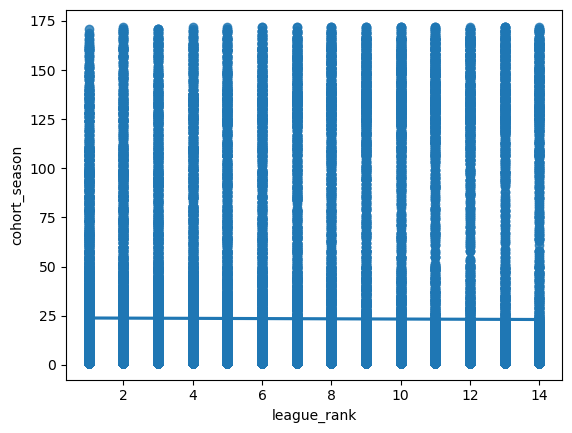

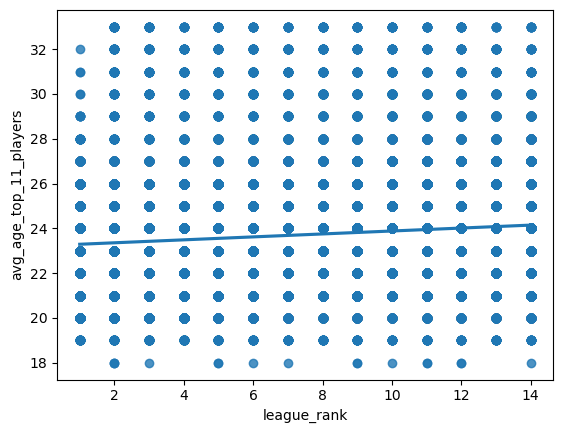

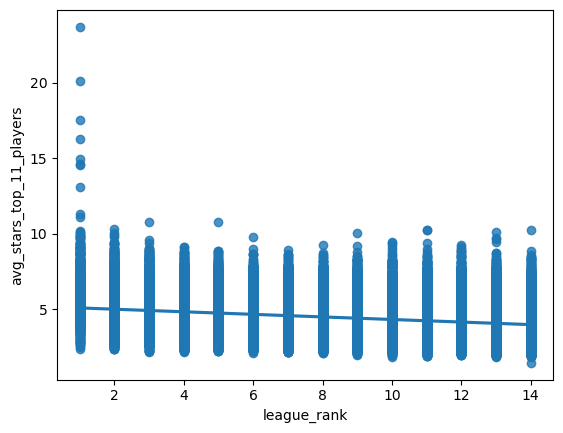

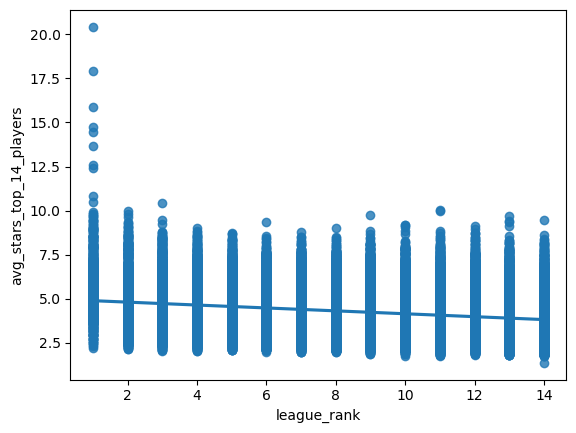

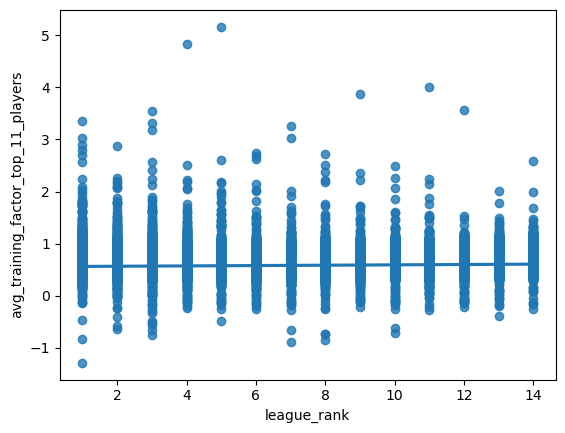

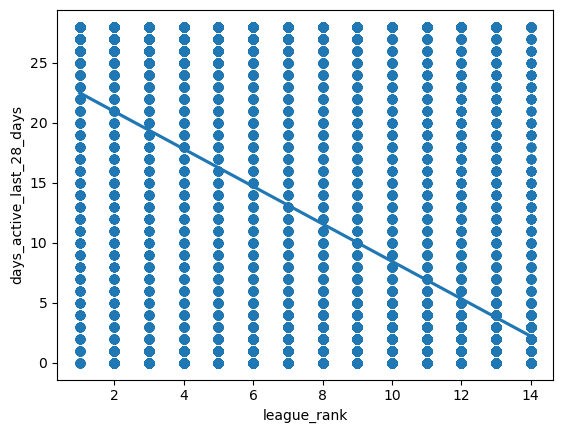

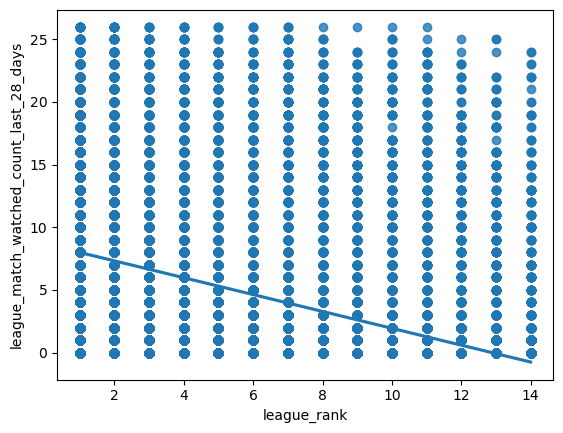

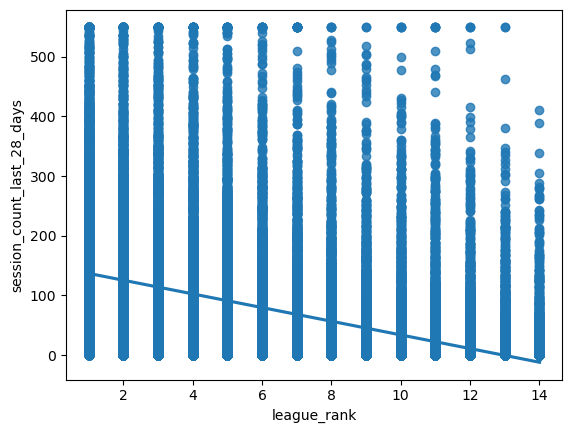

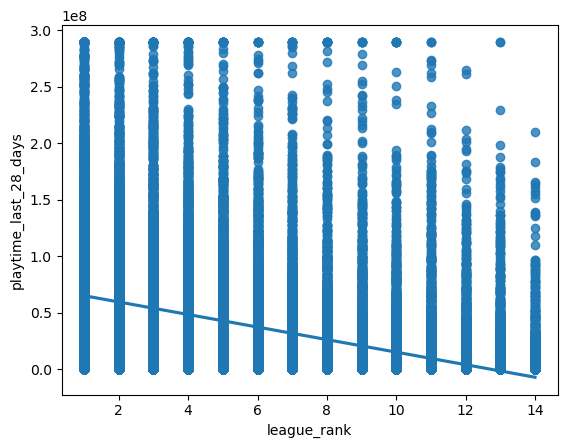

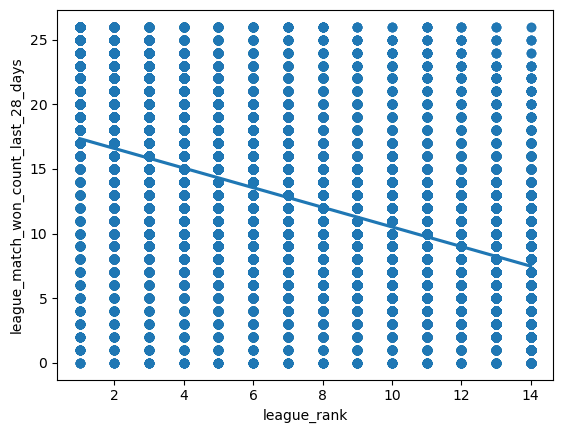

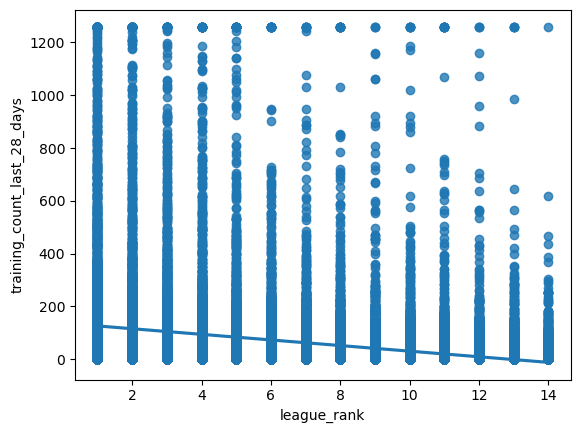

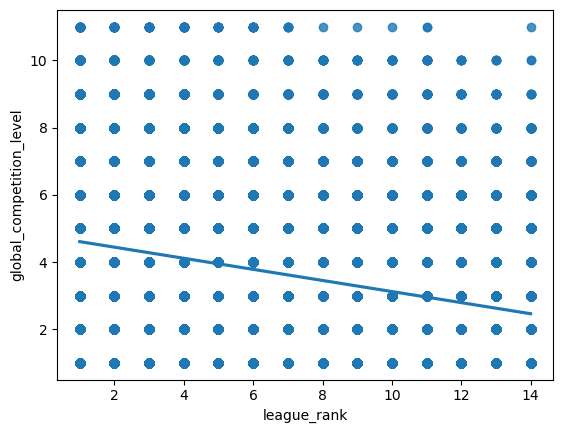

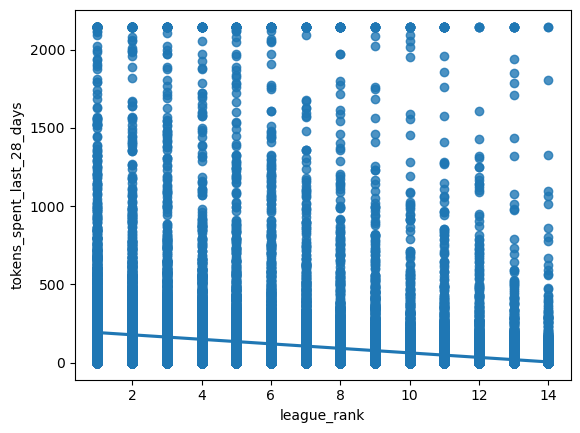

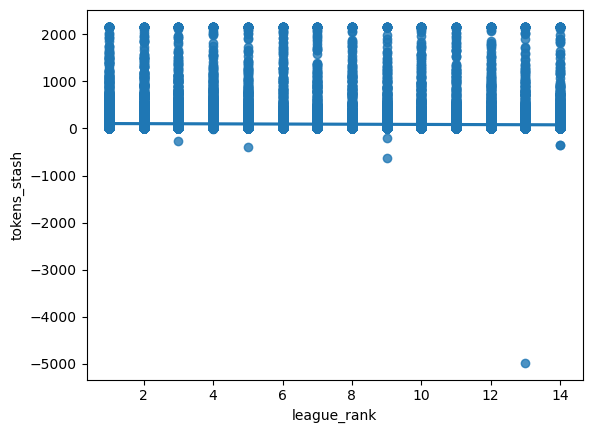

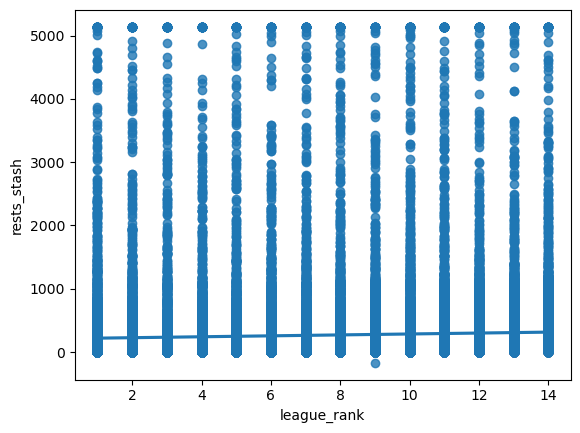

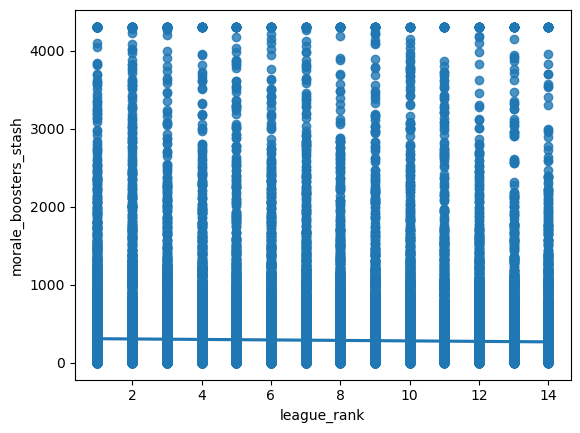

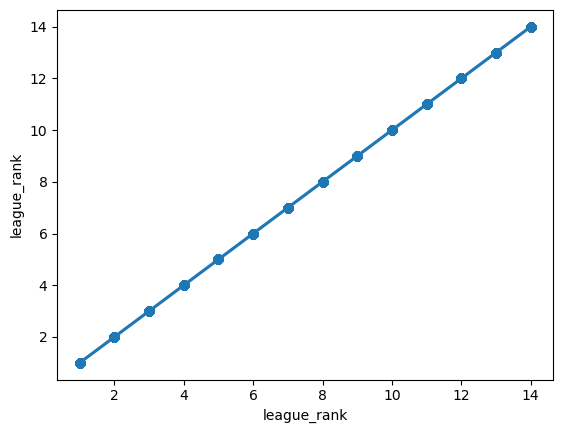

In [166]:
df_relation=df.select_dtypes(include=['float64',"int64"]).drop(["season","club_id","league_id"],axis=1)
for col in list(df_relation.columns):
    sns.regplot(data=df_relation,x="league_rank",y=col)
    plt.show() 
    

- We can see that some linear relationship exists between the target and predictor variable, but my guess is that Random Forest and XGBoost will do a better job since they are better suited for non-linear data

- Since the correlation matrix will be quite big , let's just focus on league_rank for now

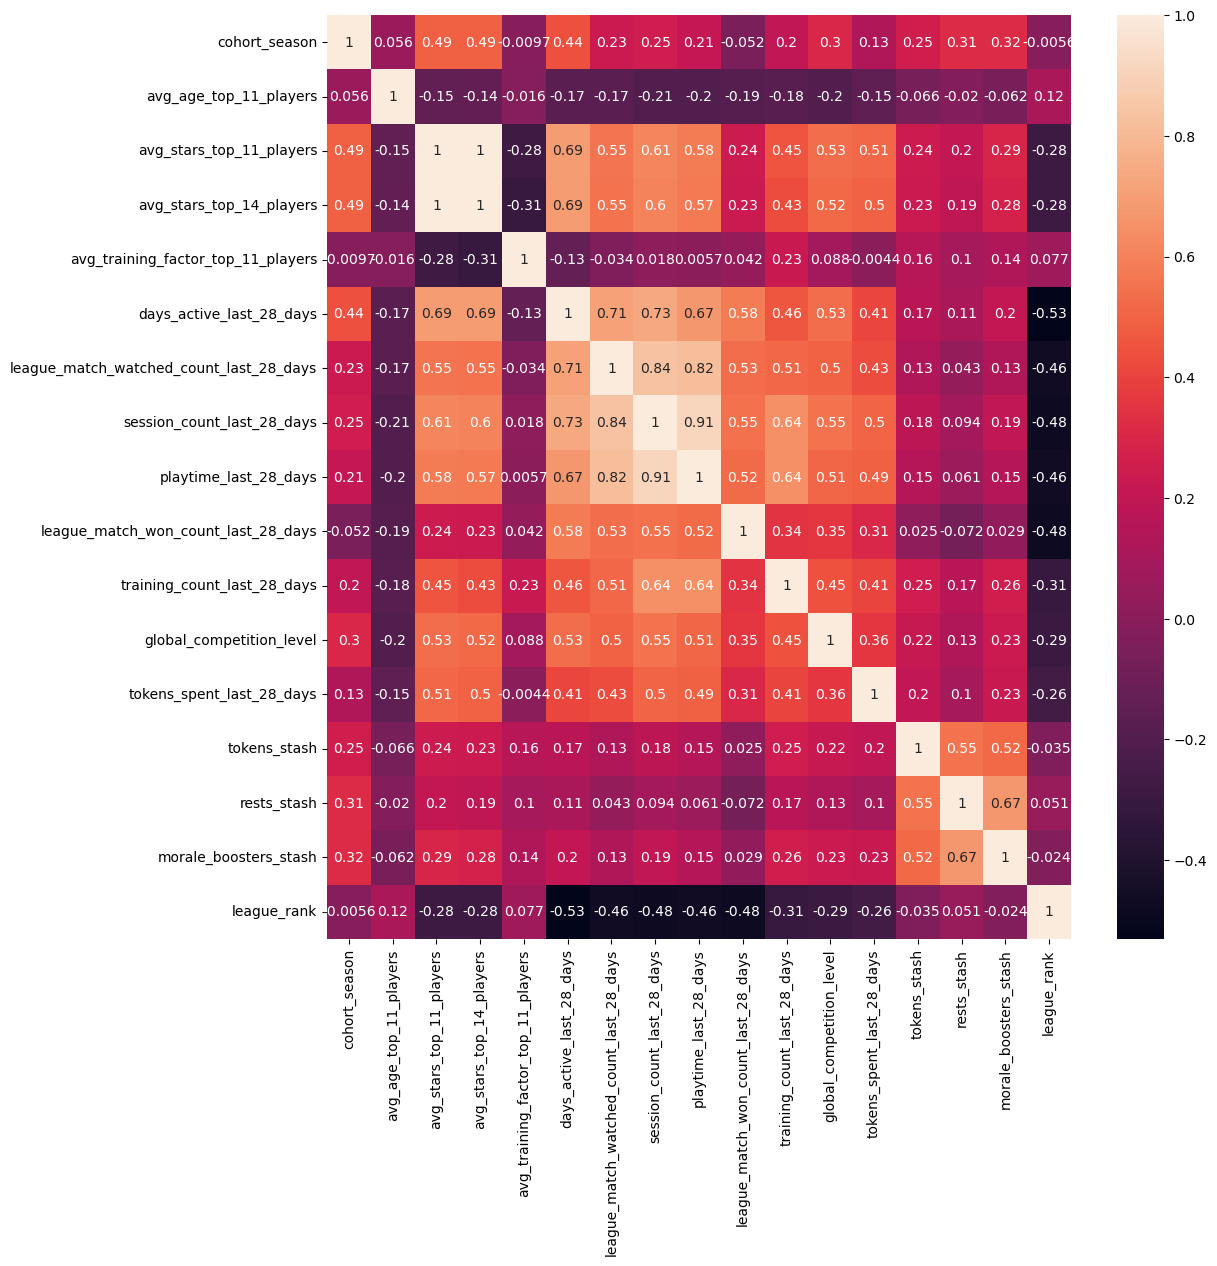

In [167]:
fig, ax = plt.subplots(figsize=(12,12))
hm = sns.heatmap(df_relation.corr(), annot = True)

- Many of the features are negatively correlated with the target variable, which we would expect, since for example the more matches you won, the lower will be your ranking, which in this case is good!

- Later since I will be running stepwise regression, I want to see which variables are highly correlated and should be dropped to avoid multicollinearity

In [168]:
multi_corr=df_relation.corr().abs().unstack().reset_index().rename(columns=({"level_0":"var1","level_1":"var2",0:"corr_coeff"}))
multi_corr[(multi_corr["corr_coeff"]>0.8) & (multi_corr["corr_coeff"]<1)].sort_values("corr_coeff",ascending=False).iloc[::2,:]

,var1,var2,corr_coeff
37,avg_stars_top_11_players,avg_stars_top_14_players,0.996793
127,session_count_last_28_days,playtime_last_28_days,0.911379
109,league_match_watched_count_last_28_days,session_count_last_28_days,0.837819
110,league_match_watched_count_last_28_days,playtime_last_28_days,0.820583


## Linear Regression

- I will use statsmodels library, which is more 'R like' since scikit learn does not give coefficient signifiance values

In [169]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, r2_score

In [299]:
# define columns to run regression on

cols=[['dynamic_payment_segment','cohort_season', 'avg_age_top_11_players', 'avg_stars_top_11_players','avg_training_factor_top_11_players',
       'days_active_last_28_days','registration_country', 'registration_platform_specific',"league_match_won_count_last_28_days",\
        'training_count_last_28_days','global_competition_level', 'tokens_spent_last_28_days', 'tokens_stash','rests_stash', 'morale_boosters_stash'],


['dynamic_payment_segment','cohort_season', 'avg_age_top_11_players', 'avg_stars_top_11_players','avg_training_factor_top_11_players',
    'days_active_last_28_days', 'league_match_watched_count_last_28_days', 'playtime_last_28_days',
 'registration_platform_specific', 'training_count_last_28_days',
      'global_competition_level', 'tokens_spent_last_28_days', 'tokens_stash',
       'rests_stash','morale_boosters_stash'],
      
['dynamic_payment_segment', 'avg_age_top_11_players', 'avg_stars_top_11_players','avg_training_factor_top_11_players',
    'days_active_last_28_days', 'league_match_watched_count_last_28_days', 'playtime_last_28_days',
 'registration_platform_specific', 'training_count_last_28_days',
      'global_competition_level']]

In [25]:
def LinReg(cols):
    X=df[cols]
    
    X=pd.get_dummies(X,drop_first=True)
    
    y=df["league_rank"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    
    # Estimation

    X_train = sm.add_constant(X_train)
    olsmod = sm.OLS(y_train, X_train)
    olsres = olsmod.fit()
    print(olsres.summary())

    # Train prediction

    y_pred_train = round(olsres.predict(X_train))
    print("Mean Absolute Error on Train Set is {}".format(mean_absolute_error(y_pred_train,y_train)))
    # Test Prediction

    X_test = sm.add_constant(X_test)
    y_pred_test = round(olsres.predict(X_test))  # predict out of sample
    print("Mean Absolute Error on Test Set is {}".format(mean_absolute_error(y_pred_test,y_test)))
    
    # Check predictions based to default (mean)
    
    overall_mean_train=[df["league_rank"].mean()]*len(X_train)
    overall_mean_test=[df["league_rank"].mean()]*len(X_test)
    
    print("Mean Absolute Error on Train Set compared to sample mean {}".format(mean_absolute_error(y_train,overall_mean_train)))
    print("Mean Absolute Error on Test Set compared to sample mean {}".format(mean_absolute_error(y_test,overall_mean_test)))
    
    print("------------------------------------------------------------------------------------------------")
    

In [171]:
for lista in cols:
    LinReg(lista)

                            OLS Regression Results                            
Dep. Variable:            league_rank   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     126.9
Date:                Mon, 20 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:36:14   Log-Likelihood:            -1.1408e+05
No. Observations:               44251   AIC:                         2.286e+05
Df Residuals:                   44043   BIC:                         2.304e+05
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

- The R squared, and mean absolute errors are very similar for both models. Although I have eliminated all features with high correlation, the model suggests that there still may be some multicollinearity. 
- Next I will run Ridge Regression as it is a better choice when possibly multicollinearity exists, however I do not expect much better results
- Many countries have significant coefficients and many don't, so I was half-correct, however, dropping registration_country does lead to any significant change in R2

## Ridge

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler

In [1033]:
# Let's tune for different alpha parameters
alpha_list=[0.001,0.01,0.1,1,5,10]

for al in alpha_list:
    
    X=df.drop(["season","club_id","league_id","league_rank"],axis=1)
    
    y=df["league_rank"]
    
    # define scaler
    
    scaler = StandardScaler()
    
    # get dummies
    
    X=pd.get_dummies(X,drop_first=True)
    
    # scale features
    
    X = scaler.fit_transform(X)
    
    # split data into train and test
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    
    #Ridge Regression Model
    
    ridgereg = Ridge(alpha=al)

    ridgereg.fit(X_train,y_train)
    
    y_pred_train=round(pd.Series(ridgereg.predict(X_train)))

    y_pred_test=round(pd.Series(ridgereg.predict(X_test)))
    
    #train and test score for ridge regression
    train_score_ridge = ridgereg.score(X_train, y_train)
    test_score_ridge = ridgereg.score(X_test, y_test)
    
    overall_mean_train=[df["league_rank"].mean()]*len(X_train)
    overall_mean_test=[df["league_rank"].mean()]*len(X_test)

    print("R2 on train set is {}".format(train_score_ridge))
    print("R2 on test set is {}".format(test_score_ridge))
    
    print("Mean Absolute Error on Train Set is {}".format(mean_absolute_error(y_pred_train,y_train)))
    print("Mean Absolute Error on Test Set is {}".format(mean_absolute_error(y_pred_test,y_test)))
    
    print("Mean Absolute Error on Train Set compared to sample mean {}".format(mean_absolute_error(y_train,overall_mean_train)))
    print("Mean Absolute Error on Test Set compared to sample mean {}".format(mean_absolute_error(y_test,overall_mean_test)))
    
    print("------------------------------------------------------------------------------------------")
    

R2 on train set is 0.3807409793756147
R2 on test set is 0.37771755878906854
Mean Absolute Error on Train Set is 2.5883708842738016
Mean Absolute Error on Test Set is 2.609961131700262
Mean Absolute Error on Train Set compared to sample mean 3.4937854511762447
Mean Absolute Error on Test Set compared to sample mean 3.5248576335532857
------------------------------------------------------------------------------------------
R2 on train set is 0.38074097916539273
R2 on test set is 0.3777178977137564
Mean Absolute Error on Train Set is 2.5883708842738016
Mean Absolute Error on Test Set is 2.609961131700262
Mean Absolute Error on Train Set compared to sample mean 3.4937854511762447
Mean Absolute Error on Test Set compared to sample mean 3.5248576335532857
------------------------------------------------------------------------------------------
R2 on train set is 0.3807409597780287
R2 on test set is 0.37772084838931863
Mean Absolute Error on Train Set is 2.5883482859144427
Mean Absolute Err

- The results of Ridge regression are very similar to those of linear regression. R2 is not higher, and as I mentioned before, though there does seem to be some linear relationship between the variables and the target variable, it is not enough to produce a better R2 and a lower MAE.
- I suppose Random Forest and XGBoost will come up with better results, since they can better capture non-linearity of the data

## Random Forest

In [211]:
# pass parameters to GridSearchCV
param_grid={'max_depth': [30,50,100],
            'max_features': [3,5,7],
            'min_samples_split': [0.1,0.2,0.3],
            'n_estimators': [50,100,200]}

In [173]:
def RF(c):
    # Specify predictor variables
    X=df.drop(c,axis=1)
    
    # convert categorical data to dummy variables
    X=pd.get_dummies(X,drop_first=True)
    
    
    # Specify target variable
    
    y=df["league_rank"]
    
    # Split Data into Train and Test
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
    
    
    # define the model
    rf=RandomForestRegressor(random_state=1234)
    
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3,verbose=1)
    
    # fit the model
    grid_search.fit(X_train,y_train)
    
    # find overall mean
    
    overall_mean_train=[df["league_rank"].mean()]*len(X_train)
    overall_mean_test=[df["league_rank"].mean()]*len(X_test)
    
   #  feed optimal parameters into rf directly

    rf=grid_search.best_estimator_
    
    # fit the model
    rf.fit(X_train,y_train)
    
    
    y_pred_train=round(pd.Series(rf.predict(X_train)))
    
    r2_train=r2_score(y_train,y_pred_train)
    
    
    print("R2 on Train Set is {}".format(r2_train))
    print("Mean Absolute Error on Train Set is {}".format(mean_absolute_error(y_pred_train,y_train)))
    print("Mean Absolute Error on Train Set compared to sample mean {}".format(mean_absolute_error(y_train,overall_mean_train)))
    
    print("------------------------------------------------------------------------------------------")
    
    
    y_pred_test=round(pd.Series(rf.predict(X_test)))
    
    r2_test=r2_score(y_test,y_pred_test)

    
    print("R2 on Test Set is {}".format(r2_test))
    print("Mean Absolute Error on Test Set is {}".format(mean_absolute_error(y_pred_test,y_test)))
    print("Mean Absolute Error on Test Set compared to sample mean {}".format(mean_absolute_error(y_test,overall_mean_test)))
    
    
    feat_importances = pd.Series(rf.feature_importances_, index=list(X.columns))
    feat_importances.nlargest(20).plot(kind='barh')
    
    print(grid_search.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
R2 on Train Set is 0.34564867759267615
Mean Absolute Error on Train Set is 2.7360893495640997
Mean Absolute Error on Train Set compared to sample mean 3.4994978104535774
------------------------------------------------------------------------------------------
R2 on Test Set is 0.3505160010010314
Mean Absolute Error on Test Set is 2.7237888647866955
Mean Absolute Error on Test Set compared to sample mean 3.5045191612436732


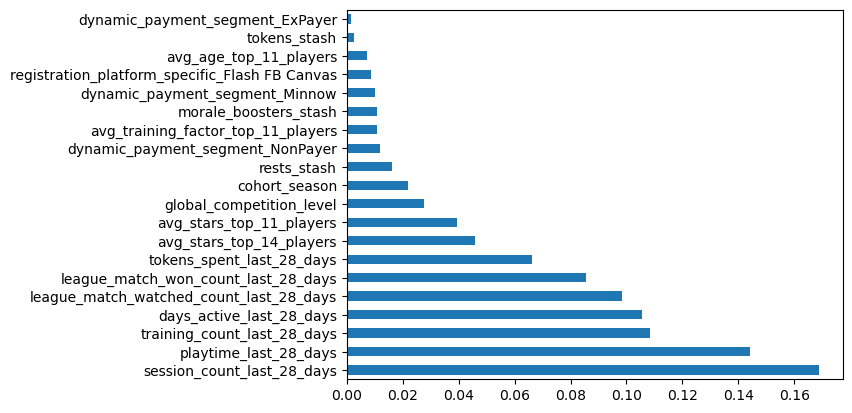

In [174]:
cols_to_drop=["season","club_id","league_id","league_rank"]
RF(cols_to_drop)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
R2 on Train Set is 0.39092614969743444
Mean Absolute Error on Train Set is 2.600457996866337
Mean Absolute Error on Train Set compared to sample mean 3.4994978104535774
------------------------------------------------------------------------------------------
R2 on Test Set is 0.3965200982488952
Mean Absolute Error on Test Set is 2.581887201735358
Mean Absolute Error on Test Set compared to sample mean 3.5045191612436732


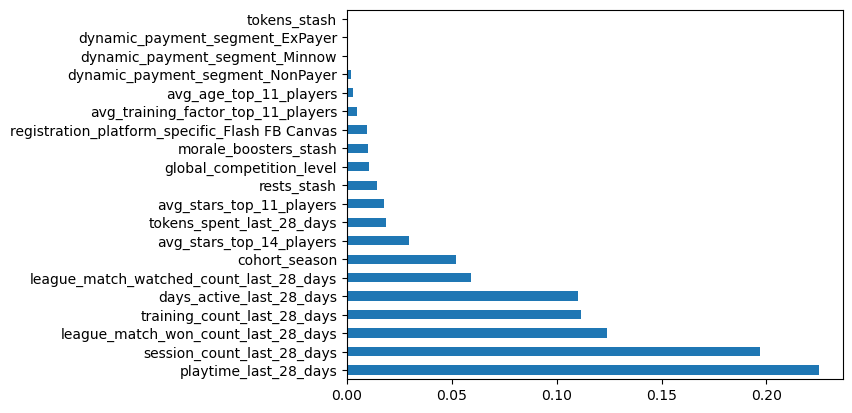

In [175]:
cols_to_drop=["season","club_id","league_rank","league_id","registration_country"]
RF(cols_to_drop)

-  In next iteration let's drop variables that have low importance

Fitting 3 folds for each of 81 candidates, totalling 243 fits
R2 on Train Set is 0.400742902987007
Mean Absolute Error on Train Set is 2.556405929854164
Mean Absolute Error on Train Set compared to sample mean 3.4994978104535774
------------------------------------------------------------------------------------------
R2 on Test Set is 0.4091859592025614
Mean Absolute Error on Test Set is 2.534345625451916
Mean Absolute Error on Test Set compared to sample mean 3.5045191612436732


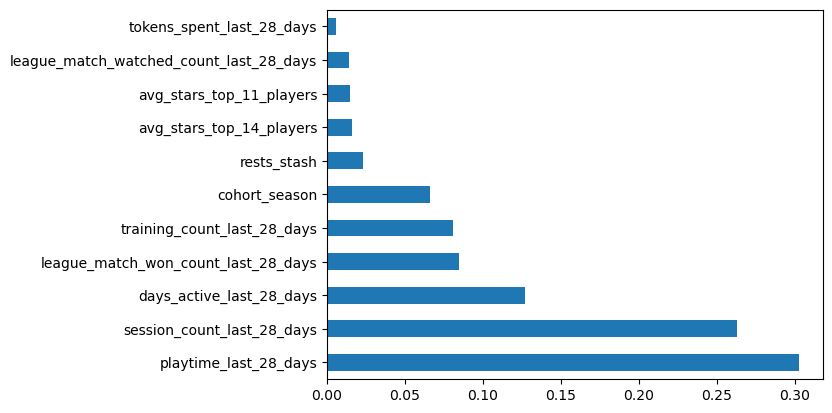

In [212]:
cols_to_drop=["season","club_id","league_id","league_rank","dynamic_payment_segment","avg_training_factor_top_11_players",\
              "avg_age_top_11_players","registration_country","global_competition_level","tokens_stash","morale_boosters_stash","registration_platform_specific"]
RF(cols_to_drop)

#### XGBoost

In [33]:
from xgboost import XGBRegressor

In [384]:
# pass parameters to GridSearchCV
param_grid={'max_depth': [4,5,6,7,8,10],
            'n_estimators': [10,15,30],
             'learning_rate':[0.1,0.2,0.3,0.5]}
cols_to_drop=["season","club_id","league_rank","league_id","global_competition_level","registration_country"]

In [220]:
def XGB(c):
    # Specify predictor variables
    X=df.drop(c,axis=1)
    
    # convert categorical data to dummy variables
    X=pd.get_dummies(X,drop_first=True)
    
    
    # Specify target variable
    
    y=df["league_rank"]
    
    # Split Data into Train and Test
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    
    
    # define the model
    xgb=XGBRegressor(random_state=1234)
    
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3,verbose=1)
    # fit the model
    grid_search.fit(X_train,y_train)
    
    overall_mean_train=[df["league_rank"].mean()]*len(X_train)
    overall_mean_test=[df["league_rank"].mean()]*len(X_test)
    
   #  feed optimal parameters into xgb directly

    xgb=grid_search.best_estimator_
    
    print(grid_search.best_estimator_)
    xgb.fit(X_train,y_train)
    
    y_pred_train=round(pd.Series(xgb.predict(X_train)))
    
    r2_train=r2_score(y_train,y_pred_train)
    
    
    print("R2 on Train Set is {}".format(r2_train))
    print("Mean Absolute Error on Train Set is {}".format(mean_absolute_error(y_pred_train,y_train)))
    print("Mean Absolute Error on Train Set compared to sample mean {}".format(mean_absolute_error(y_train,overall_mean_train)))
    
    print("------------------------------------------------------------------------------------------")
    
    
    y_pred_test=round(pd.Series(xgb.predict(X_test)))
    
    r2_test=r2_score(y_test,y_pred_test)

    
    print("R2 on Test Set is {}".format(r2_test))
    print("Mean Absolute Error on Test Set is {}".format(mean_absolute_error(y_pred_test,y_test)))
    print("Mean Absolute Error on Test Set compared to sample mean {}".format(mean_absolute_error(y_test,overall_mean_test)))
    


    feat_importances = pd.Series(xgb.feature_importances_, index=list(X.columns))
    feat_importances.nlargest(20).plot(kind='barh')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30, n_jobs=None,
             num_parallel_tree=None, random_state=1234, ...)
R2 on Train Set is 0.548875820496277
Mean Absolute Error on Train Set is 2.1845608008858557
Mean Absolute Error on Train Set compared to sample mean 3.4937854511762447
-----------------------------

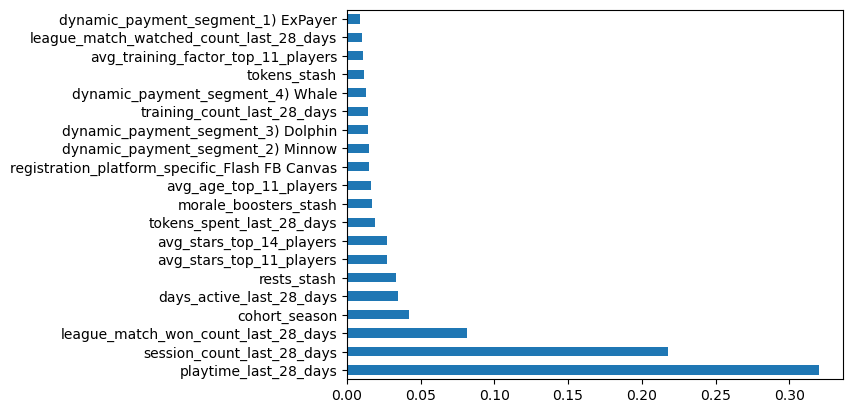

In [385]:
XGB(cols_to_drop)

- XGBoost with max_depth=8,learning_rate=0.1 and n_estimators=30 has proven to be the best model, it has the lowest MAE and the highest R2. There is a slight overfit compared to the train set.

## Make Predictions on Test Set

In [365]:
# load test set
df_test=pd.read_csv("league_rank_test.csv")

- I realise now since global competition level contains NaN in test set I will have to drop this variable, however it has a very low importance anyways, so it will not affect the results

In [377]:
# I will concatenate these later once I am done with predictions

cols_to_drop=["season","league_id","club_id","global_competition_level","registration_country","league_rank"]

X=df.drop(cols_to_drop,axis=1)

# convert categorical data to dummy variables
X=pd.get_dummies(X,drop_first=True)
    
# Specify target variable
    
y=df["league_rank"]
    

#define the model
xgb=XGBRegressor(max_depth=8,learning_rate=0.1,n_estimators=30,random_state=1234)

# fit model

xgb.fit(X,y)

# specify dataset for prediction

df_club_id=df_test["club_id"]

df_for_prediction=df_test.drop(["season","league_id","club_id","global_competition_level","registration_country"],axis=1)

df_for_prediction=pd.get_dummies(df_for_prediction,drop_first=True)

# predict
league_rank=round(pd.Series(xgb.predict(df_for_prediction)))
df_club_id=pd.DataFrame(df_club_id)
df_club_id["league_rank"]=league_rank

In [380]:
df_club_id

,club_id,league_rank
0,14542747,8.0
1,11019672,5.0
2,14358567,8.0
3,14644461,11.0
4,13718978,4.0
...,...,...
60265,14614619,3.0
60266,13805591,11.0
60267,14559860,6.0
60268,14671631,4.0
